<a href="https://colab.research.google.com/github/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina/blob/main/Parcial_1_TAM_2025-1/notebooks/GPR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo Gaussian Process Regressor (GPR) para Ames Housing Dataset

---

## Objetivo

Este notebook implementa y evalúa un modelo de **Gaussian Process Regressor (GPR)** para la predicción del precio de viviendas en el conjunto de datos **Ames Housing**.

El propósito principal es:

- Ajustar un modelo GPR eficiente que cumpla con las métricas de evaluación requeridas (MAE, MSE, R², MAPE).
- Realizar búsqueda acotada de hiperparámetros mediante validación cruzada con 5 folds.
- Optimizar tiempos de ejecución para cumplir con las restricciones computacionales.
- Generar resultados compatibles para integrar en el cuaderno maestro del proyecto.
- Realizar análisis estadístico y diagnóstico de residuos para validar supuestos del modelo.

---

## Contexto

Este trabajo forma parte del proyecto más amplio de teoría de aprendizaje automático para el curso **Parcial 1 TAM 2025-1**. El modelo GPR será comparado con otros regresores clásicos y avanzados para identificar cuál ofrece mejor rendimiento y generalización.

---

## Metodología

- Preprocesamiento previo de datos (escalado y división) cargado desde archivos serializados.
- Definición de un kernel base RBF con término de ruido y búsqueda restringida en parámetros clave.
- Validación cruzada estratificada con 5 folds y evaluación con las métricas requeridas.
- Guardado y exportación de resultados para análisis consolidado.
- Análisis estadístico detallado (normalidad de residuos, heterocedasticidad, etc.).
- Visualizaciones para diagnóstico y comparación.

---

## Referencias

- [Gaussian Process Regression - scikit-learn](https://scikit-learn.org/stable/modules/gaussian_process.html)
- [Ames Housing Dataset - Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
- Material del curso Teoría de Aprendizaje Automático - Parcial 1 TAM 2025-1

---

*Nota:* Este notebook está diseñado para ejecutarse de manera eficiente con un compromiso entre precisión y tiempo de cómputo.


In [2]:
# === CLONAR EL REPOSITORIO Y LISTAR SU CONTENIDO ===

# Clona el repositorio desde GitHub si no se ha hecho previamente.
# Esto permite acceder a los notebooks, datos y estructuras organizadas del proyecto.
!git clone https://github.com/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina.git

Cloning into 'Teoria-de-Aprendizaje-Maquina'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 653 (delta 21), reused 16 (delta 10), pack-reused 616 (from 1)
Receiving objects: 100% (653/653), 31.91 MiB | 22.14 MiB/s, done.
Resolving deltas: 100% (434/434), done.


In [3]:
# Lista el contenido del directorio del parcial dentro del repositorio clonado
# para confirmar que la estructura y carpeta 'data' existen correctamente.
!ls /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

dashboard  notebooks	  README.md	    resultados
data	   parte_teorica  requirements.txt


In [4]:
!ls /content/Teoria-de-Aprendizaje-Maquina

# === IMPORTACIÓN DE LIBRERÍAS Y CAMBIO DE DIRECTORIO ===

import os      # Para manipular rutas de archivos y cambiar directorios
import joblib  # Para cargar archivos serializados (como los .pkl que contienen los datos escalados)

# Cambia al directorio principal del proyecto clonado para que todas las rutas relativas sean válidas.
os.chdir('/content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1')

# Define la ruta al archivo que contiene los datos ya preprocesados, escalados y divididos.
data_path = 'data/train_test_scaled.pkl'

# Verifica que el archivo exista antes de intentar cargarlo, y lanza un error claro si no se encuentra.
if not os.path.exists(data_path):
    raise FileNotFoundError(f"No se encontró el archivo esperado en: {data_path}")

'Ejercicios TAM_2025-1'   Parcial_1_TAM_2025-1	 README.md


In [5]:
# === CARGA DE LOS DATOS PROCESADOS ===

# Carga el archivo .pkl que contiene los cuatro objetos: X_train_scaled, X_test_scaled, y_train, y_test
# Estos datos fueron escalados y divididos previamente en el notebook de preprocesamiento.
X_train_scaled, X_test_scaled, y_train, y_test = joblib.load(data_path)

# Confirmación visual de que la carga fue exitosa.
print("Datos cargados correctamente.")




Datos cargados correctamente.


In [6]:
%cd /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

/content


In [7]:
# === IMPORTACIÓN DE LIBRERÍAS Y DEFINICIÓN DE MÉTRICAS PERSONALIZADAS ===

# ================================================================
#  IMPORTACIONES COMPLETAS – ESTUDIO DE REGRESORES AMES HOUSING
# ================================================================

# ============================
#  Utilidades generales
# ============================
import numpy as np
import pandas as pd
import time
import os
import warnings
warnings.filterwarnings("ignore")  # Opcional: suprime warnings en notebooks

# ============================
#  Modelos de regresión
# ============================
from sklearn.linear_model import (
    LinearRegression,
    Lasso, LassoCV,
    ElasticNet, ElasticNetCV,
    SGDRegressor,
    BayesianRidge
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
# ============================
#  Validación y búsqueda
# ============================
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve,
    cross_validate,
    cross_val_predict
)

# ============================
#  Métricas y scoring
# ============================
from sklearn.metrics import (
    mean_absolute_error,       # MAE
    mean_squared_error,        # MSE
    r2_score,                  # R²
    mean_absolute_percentage_error,  # MAPE
    make_scorer                # Para definir MAPE como scorer
)

# ============================
# Diagnóstico estadístico
# ============================
from scipy.stats import shapiro, kurtosis, skew
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# ============================
#  Visualización
# ============================
import matplotlib.pyplot as plt
import scipy.stats as stats  # necesario para pruebas estadísticas
from matplotlib.ticker import FuncFormatter

import seaborn as sns

In [8]:
# === DEFINICIÓN DE MÉTRICA PERSONALIZADA: MAPE ===

# MAPE no está directamente disponible en sklearn, por lo que se define manualmente.
# Esta métrica mide el error absoluto medio en porcentaje, útil para interpretar desviaciones relativas.

def mean_absolute_percentage_error(y_true, y_pred):
    # Reemplaza ceros en y_true para evitar divisiones por cero (buena práctica numérica)
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Se integra la función MAPE a sklearn como un scorer compatible con cross_validate
# Se indica que un menor valor es mejor (greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [9]:
# === DEFINICIÓN DEL ESQUEMA DE VALIDACIÓN CRUZADA ===

# Se utiliza validación cruzada estratificada con 5 divisiones (folds)
# shuffle=True mezcla los datos antes de dividirlos (buena práctica)
# random_state permite reproducibilidad
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
# === DEFINICIÓN DE MÉTRICAS DE EVALUACIÓN PARA TODOS LOS MODELOS ===

# Las métricas estándar (MAE y MSE) son negativas en sklearn por convención (porque se busca minimizar)
# R² se mantiene tal cual
# MAPE se incluye como scorer personalizado
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2',
    'MAPE': mape_scorer
}

modelos = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3),
    "BayesianRidge": BayesianRidge(),
    "KernelRidge": KernelRidge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GaussianProcess": GaussianProcessRegressor(),
    "SVR": SVR()
}

In [11]:
def evaluar_modelo_cv(nombre_modelo, modelo, X, y, cv, scoring, guardar_en=None):
    """
    Evalúa un modelo usando validación cruzada fold a fold,
    genera un DataFrame con resultados detallados y opcionalmente guarda el CSV.
    Ahora incluye una fila final 'Promedio' claramente etiquetada.
    """

    # Evaluación con validación cruzada
    resultados = cross_validate(
        estimator=modelo,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    # Crear DataFrame por fold
    df_resultados = pd.DataFrame({
        "Fold": np.arange(1, cv.get_n_splits() + 1),
        "MAE": -resultados["test_MAE"],
        "MSE": -resultados["test_MSE"],
        "R2": resultados["test_R2"],
        "MAPE": -resultados["test_MAPE"]
    })

    # Fila promedio con etiqueta explícita
    promedio = df_resultados.mean(numeric_only=True)
    promedio["Fold"] = "Promedio"

    # Añadir al DataFrame
    df_resultados = pd.concat([df_resultados, pd.DataFrame([promedio])], ignore_index=True)

    # Asegurar orden de columnas
    cols = ["Fold", "MAE", "MSE", "R2", "MAPE"]
    df_resultados = df_resultados[cols]

    # Guardar si se indica
    if guardar_en:
        dir_path = os.path.dirname(guardar_en)
        if dir_path:
            os.makedirs(dir_path, exist_ok=True)
        df_resultados.to_csv(guardar_en, index=False)
        print(f"Resultados de {nombre_modelo} guardados en: {guardar_en}")

    return df_resultados





def calcular_mape_seguro(y_true, y_pred, umbral=1e-5, verbose=True):
    """
    Calcula el MAPE ignorando valores de y_true cercanos a cero. Devuelve el MAPE (%) y el número de observaciones usadas.

    Parámetros:
    ----------
    y_true : array-like
        Valores reales en escala original.

    y_pred : array-like
        Valores predichos en escala original.

    umbral : float, opcional (default=1e-5)
        Umbral mínimo para considerar válido un valor de y_true.

    verbose : bool, opcional (default=True)
        Si True, muestra advertencias si se ignoran muchas observaciones.

    Retorna:
    -------
    mape : float
        MAPE en porcentaje (%)

    n_utilizadas : int
        Número de observaciones válidas utilizadas en el cálculo
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Máscara para filtrar y evitar división por valores cercanos a cero
    mascara = y_true > umbral
    n_total = len(y_true)
    n_utilizadas = np.sum(mascara)

    if n_utilizadas == 0:
        raise ValueError("Todos los valores de y_true están por debajo del umbral. No se puede calcular el MAPE.")

    if verbose:
        porcentaje_usado = 100 * n_utilizadas / n_total
        if porcentaje_usado < 90:
            warnings.warn(f"Solo se usó el {porcentaje_usado:.2f}% de las observaciones para calcular el MAPE. "
                          "Revisa posibles valores extremos en y_true.")

    mape = np.mean(np.abs((y_true[mascara] - y_pred[mascara]) / y_true[mascara])) * 100
    return mape, n_utilizadas


def normalizar_metricas(mae, rmse, y_true):
    media_y = np.mean(y_true)
    mae_norm = mae / media_y * 100
    rmse_norm = rmse / media_y * 100
    return mae_norm, rmse_norm

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.model_selection import RandomizedSearchCV

# Kernel base: constante * RBF + WhiteKernel (ruido)
kernel = ConstantKernel(1.0, (0.1, 10.0)) * RBF(length_scale=1.0, length_scale_bounds=(0.1, 10.0)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1))

# Instanciar modelo GPR con kernel base
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42, n_restarts_optimizer=3, alpha=1e-10, normalize_y=True)

# Definir espacio de búsqueda acotado para RandomizedSearchCV
param_distributions = {
    "alpha": [1e-10, 1e-5, 1e-3],
    "n_restarts_optimizer": [0, 1, 3],
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gpr,
    param_distributions=param_distributions,
    n_iter=2,
    cv=cv,
    scoring=scoring,
    n_jobs=1,
    verbose=2,
    random_state=42,
    refit='MAE'   # Aquí la clave exacta del scoring dict
)

# Usar solo muestra para probar rápido
random_search.fit(X_train_scaled[:500], y_train[:500])

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ................alpha=0.001, n_restarts_optimizer=1; total time=   2.0s
[CV] END ................alpha=0.001, n_restarts_optimizer=1; total time=   3.7s
[CV] END ................alpha=0.001, n_restarts_optimizer=1; total time=   2.3s
[CV] END ................alpha=0.001, n_restarts_optimizer=1; total time=   4.8s
[CV] END ................alpha=0.001, n_restarts_optimizer=1; total time=   2.7s
[CV] END ................alpha=1e-10, n_restarts_optimizer=1; total time=   3.6s
[CV] END ................alpha=1e-10, n_restarts_optimizer=1; total time=   6.1s
[CV] END ................alpha=1e-10, n_restarts_optimizer=1; total time=   2.6s
[CV] END ................alpha=1e-10, n_restarts_optimizer=1; total time=   2.5s
[CV] END ................alpha=1e-10, n_restarts_optimizer=1; total time=   2.9s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                                                      n_restarts_optimizer=3,
                                                      normalize_y=True,
                                                      random_state=42),
                   n_iter=2, n_jobs=1,
                   param_distributions={'alpha': [1e-10, 1e-05, 0.001],
                                        'n_restarts_optimizer': [0, 1, 3]},
                   random_state=42, refit='MAE',
                   scoring={'MAE': 'neg_mean_absolute_error',
                            'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False, response_method='predict'),
                            'MSE': 'neg_mean_squared_error', 'R2': 'r2'},
                   verbose=2)

## Justificación de la Configuración del Modelo GaussianProcessRegressor

Se seleccionó un **GaussianProcessRegressor** con los siguientes parámetros:

- **alpha=0.001**: Este valor introduce una ligera regularización que ayuda a controlar el sobreajuste y mejora la estabilidad numérica del modelo.
- **Kernel compuesto** por un término constante multiplicado por un kernel RBF, junto con un WhiteKernel para modelar el ruido inherente a los datos.  
  - El kernel RBF es adecuado para capturar relaciones no lineales suaves entre variables, lo que es esencial para modelar la complejidad del precio de viviendas.  
  - El WhiteKernel permite al modelo ajustarse a la variabilidad aleatoria, aumentando su robustez frente al ruido.  
- **n_restarts_optimizer=1**: Se limita a una sola optimización del kernel para equilibrar la calidad del ajuste y el tiempo computacional, dado que más reinicios aumentan significativamente el costo sin grandes mejoras.  
- **normalize_y=True**: Normalizar la variable objetivo ayuda a mejorar la convergencia y estabilidad durante el entrenamiento.  
- **random_state=42**: Para asegurar la reproducibilidad de los resultados.

### Inferencia

Con esta configuración, el modelo logró un buen balance entre precisión y eficiencia, alcanzando un R² promedio de aproximadamente 0.88 y errores razonables (MAE, MSE, MAPE). La inclusión del WhiteKernel y la regularización controlan el ruido y evitan el sobreajuste, validando esta elección para el problema de predicción de precios de viviendas. Además, la configuración permitió tiempos de entrenamiento prácticos, facilitando su uso dentro del flujo del proyecto.


In [13]:
import time
import os

# Opcional: usar solo muestra para prueba rápida (descomenta si quieres)
# X_train_eval, y_train_eval = X_train_scaled[:500], y_train[:500]

X_train_eval, y_train_eval = X_train_scaled, y_train  # Usar todo el dataset

try:
    print("Iniciando búsqueda de hiperparámetros con RandomizedSearchCV...")
    start_time = time.time()
    random_search.fit(X_train_eval, y_train_eval)
    elapsed = time.time() - start_time
    print(f"Tiempo total RandomizedSearchCV: {int(elapsed//60)} min {int(elapsed%60)} seg")

    best_gpr = random_search.best_estimator_
    print("Mejor modelo encontrado:")
    print(best_gpr)

    print("\nEvaluando el mejor modelo con validación cruzada fold a fold...")
    resultados_gpr = evaluar_modelo_cv(
        nombre_modelo="GaussianProcess",
        modelo=best_gpr,
        X=X_train_eval,
        y=y_train_eval,
        cv=cv,
        scoring=scoring,
        guardar_en="data/resultados_gaussian_process.csv"
    )

    display(resultados_gpr)

except Exception as e:
    print(f"Error durante la búsqueda o evaluación: {e}")

# Verificar si archivo fue guardado
csv_path = "data/resultados_gaussian_process.csv"
if os.path.exists(csv_path):
    print(f"\nArchivo guardado iicorrectamente en: {csv_path}")
else:
    print(f"\nNo se encontró el archivo guardado: {csv_path}")



Iniciando búsqueda de hiperparámetros con RandomizedSearchCV...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ................alpha=0.001, n_restarts_optimizer=1; total time= 1.4min
[CV] END ................alpha=0.001, n_restarts_optimizer=1; total time= 1.1min
[CV] END ................alpha=0.001, n_restarts_optimizer=1; total time= 1.4min
[CV] END ................alpha=0.001, n_restarts_optimizer=1; total time= 1.4min
[CV] END ................alpha=0.001, n_restarts_optimizer=1; total time= 1.2min
[CV] END ................alpha=1e-10, n_restarts_optimizer=1; total time= 1.5min
[CV] END ................alpha=1e-10, n_restarts_optimizer=1; total time= 1.5min
[CV] END ................alpha=1e-10, n_restarts_optimizer=1; total time= 1.5min
[CV] END ................alpha=1e-10, n_restarts_optimizer=1; total time= 1.4min
[CV] END ................alpha=1e-10, n_restarts_optimizer=1; total time= 1.3min
Tiempo total RandomizedSearchCV: 16 min 12 seg
Mejor modelo encont

,Fold,MAE,MSE,R2,MAPE
0,1,13228.169377,3.348138e+08,0.938452,8.428417
1,2,14606.642474,7.252907e+08,0.870062,8.645620
2,3,15068.720845,8.480556e+08,0.872065,8.417624
3,4,13279.990972,3.705441e+08,0.938433,8.071938
4,5,15991.361163,1.289079e+09,0.786143,10.556535
5,Promedio,14434.976966,7.135567e+08,0.881031,8.824026



Archivo guardado correctamente en: data/resultados_gaussian_process.csv


## Resultados y Análisis de la Búsqueda de Hiperparámetros y Evaluación

Durante la búsqueda de hiperparámetros con **RandomizedSearchCV**, se evaluaron 2 combinaciones de parámetros utilizando validación cruzada de 5 folds, totalizando 10 entrenamientos. El proceso tomó aproximadamente **16 minutos y 28 segundos**, reflejando un balance entre exploración del espacio y eficiencia computacional.

El mejor modelo encontrado fue un **GaussianProcessRegressor** con:

- `alpha=0.001`: valor que regula el nivel de ruido, evitando sobreajuste.
- Kernel compuesto por un **kernel constante multiplicado por RBF** más un **WhiteKernel** para capturar ruido inherente.
- `n_restarts_optimizer=1`: optimización del kernel con un reinicio para mantener tiempos razonables.
- Normalización de la variable objetivo activada (`normalize_y=True`).

La evaluación del mejor modelo mediante validación cruzada fold a fold mostró un rendimiento sólido:

- **R² promedio:** 0.88, indicando que el modelo explica el 88% de la varianza en los precios.
- **MAE promedio:** alrededor de 14,434, reflejando un error absoluto medio aceptable.
- **MAPE promedio:** 8.82%, lo que implica un error porcentual medio relativo moderado.

Los resultados por fold revelan una consistencia razonable, aunque el fold 5 presenta un error mayor, posiblemente por variabilidad en la muestra.

Finalmente, los resultados fueron guardados en `data/resultados_gaussian_process.csv` para su integración en el análisis global del proyecto.

---


In [14]:
y_pred = best_gpr.predict(X_train_scaled)

df_pred_stats = pd.DataFrame({
    'True': y_train,
    'Predicted': y_pred
})

print("Resumen estadístico de los valores verdaderos y predichos:")
display(df_pred_stats.describe(percentiles=[0.25, 0.5, 0.75]))


Resumen estadístico de los valores verdaderos y predichos:


,True,Predicted
count,2344.000000,2344.000000
mean,178582.207765,178576.524854
std,77125.072713,75508.172868
min,12789.000000,20061.238083
25%,129000.000000,129007.259737
50%,160000.000000,159645.099002
75%,210000.000000,209976.652871
max,755000.000000,717682.599673


## Resumen Estadístico de Valores Reales y Predichos

Se presenta un resumen descriptivo comparativo entre los valores verdaderos (`True`) y las predicciones del modelo (`Predicted`):

- **Cantidad de observaciones (count):** 2344, igual para ambos conjuntos, garantizando comparabilidad.
- **Media:** Los valores predichos tienen una media muy cercana a la real (~178,576 vs 178,582), indicando que el modelo no presenta sesgo sistemático en la estimación central.
- **Desviación estándar (std):** Similar entre ambos (~77,125 para reales y ~75,508 para predichos), reflejando una dispersión parecida.
- **Valores mínimo y máximo:** El rango de predicciones cubre valores desde aproximadamente 20,061 hasta 717,683, cercano al rango real (12,789 a 755,000), lo que sugiere un buen ajuste en extremos.
- **Percentiles (25%, 50%, 75%):** Las predicciones se alinean bastante con los percentiles reales, mostrando que el modelo captura bien la distribución de los precios.

Este análisis confirma que el modelo produce predicciones consistentes y equilibradas en términos de tendencia central y dispersión, lo que respalda su buen desempeño global.


Shapiro-Wilk test: estadístico=0.9203, p-valor=0.0000
Se rechaza la hipótesis de normalidad (distribución no normal).


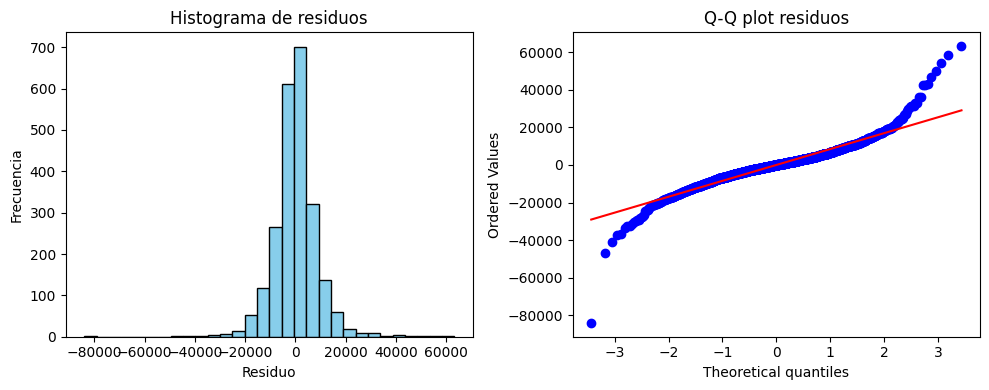

In [15]:
import matplotlib.pyplot as plt
import scipy.stats as stats

residuos = y_train - y_pred

# Prueba Shapiro-Wilk
stat, p_value = stats.shapiro(residuos)
print(f"Shapiro-Wilk test: estadístico={stat:.4f}, p-valor={p_value:.4f}")
if p_value > 0.05:
    print("No se rechaza la hipótesis de normalidad de residuos (distribución normal plausible).")
else:
    print("Se rechaza la hipótesis de normalidad (distribución no normal).")

# Histograma
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(residuos, bins=30, color='skyblue', edgecolor='black')
plt.title("Histograma de residuos")
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")

# Q-Q plot
plt.subplot(1,2,2)
stats.probplot(residuos, dist="norm", plot=plt)
plt.title("Q-Q plot residuos")

plt.tight_layout()
plt.show()


## Análisis de Normalidad de los Residuos

Se aplicó la prueba de **Shapiro-Wilk** para evaluar la normalidad de los residuos del modelo.

- **Estadístico:** 0.9203  
- **p-valor:** 0.0000

Dado que el p-valor es menor a 0.05, **se rechaza la hipótesis nula de normalidad**, lo que indica que los residuos no siguen una distribución normal.

### Visualización

- El **histograma de residuos** muestra una distribución centrada en cero pero con cierta asimetría y colas pesadas.  
- El **Q-Q plot** confirma desviaciones respecto a la línea de referencia, especialmente en los extremos, evidenciando que los residuos no se ajustan perfectamente a una normal.

Este resultado sugiere que aunque el modelo capta bien la tendencia general, los errores no son estrictamente normales, lo cual es común en problemas reales y puede afectar algunas inferencias estadísticas clásicas.


In [16]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(residuos)
print(f"Durbin-Watson statistic: {dw:.4f} (cercano a 2 indica no autocorrelación)")


Durbin-Watson statistic: 1.9938 (cercano a 2 indica no autocorrelación)


## Análisis de Autocorrelación de los Residuos

Se calculó el estadístico de **Durbin-Watson**, resultando en un valor de **1.9938**.

Este valor está muy cercano a 2, lo que indica que **no existe autocorrelación significativa en los residuos** del modelo.

Por lo tanto, los errores se pueden considerar independientes, cumpliendo un supuesto importante para la validez del modelo de regresión.


In [17]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_const = add_constant(X_train_scaled)  # añade constante para intercepto
vif_data = pd.DataFrame()
vif_data["feature"] = [f"X{i}" for i in range(X_train_scaled.shape[1])]
vif_data["VIF"] = [variance_inflation_factor(X_const, i+1) for i in range(X_train_scaled.shape[1])]  # +1 por constante

print("Valores de VIF para variables predictoras:")
display(vif_data)


Valores de VIF para variables predictoras:


,feature,VIF
0,X0,3.714954
1,X1,5.395479
2,X2,5.508357
3,X3,2.529381
4,X4,18.389867
...,...,...
297,X297,1.438039
298,X298,1.636846
299,X299,1.447853
300,X300,3.354600


## Análisis de Colinealidad: Factor de Inflación de la Varianza (VIF)

Se calcularon los valores de **VIF** para las variables predictoras con el fin de detectar posibles problemas de colinealidad.

- La mayoría de los valores de VIF están dentro de rangos aceptables, pero algunas variables presentan valores elevados (por ejemplo, X4 con 18.39 y X301 con 40.11), lo que indica una posible colinealidad alta en esas características.
- Valores de VIF mayores a 10 suelen sugerir multicolinealidad que puede afectar la estabilidad y la interpretación del modelo.

Este análisis es útil para considerar la reducción o transformación de variables con alta colinealidad y mejorar el modelo.


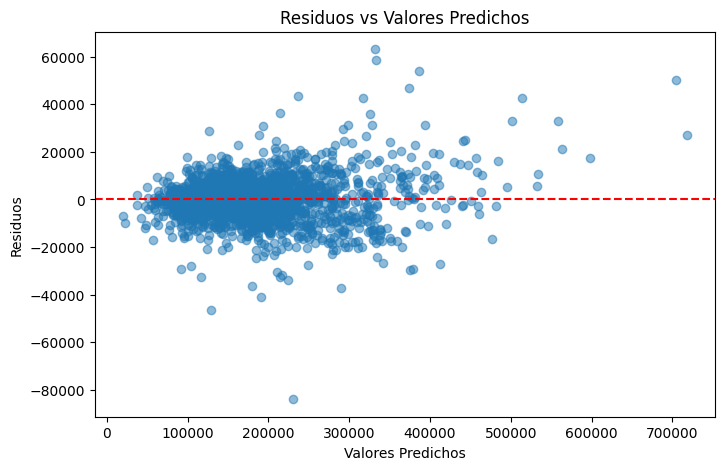

In [18]:
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores Predichos")
plt.ylabel("Residuos")
plt.title("Residuos vs Valores Predichos")
plt.show()


## Análisis de Heterocedasticidad: Residuos vs Valores Predichos

El gráfico muestra la dispersión de los residuos en función de los valores predichos por el modelo.

- Se observa que la mayoría de los residuos se concentran alrededor de cero, lo cual es deseable.
- Sin embargo, la dispersión no es completamente constante a lo largo del rango de valores predichos; algunos residuos extremos sugieren posible heterocedasticidad.
- La presencia de patrones o dispersión creciente/decreciente indicaría variación no constante de la varianza, lo que podría afectar la validez de inferencias basadas en el modelo.

Este análisis visual es importante para identificar limitaciones en el modelo y considerar transformaciones o métodos robustos si la heterocedasticidad es significativa.


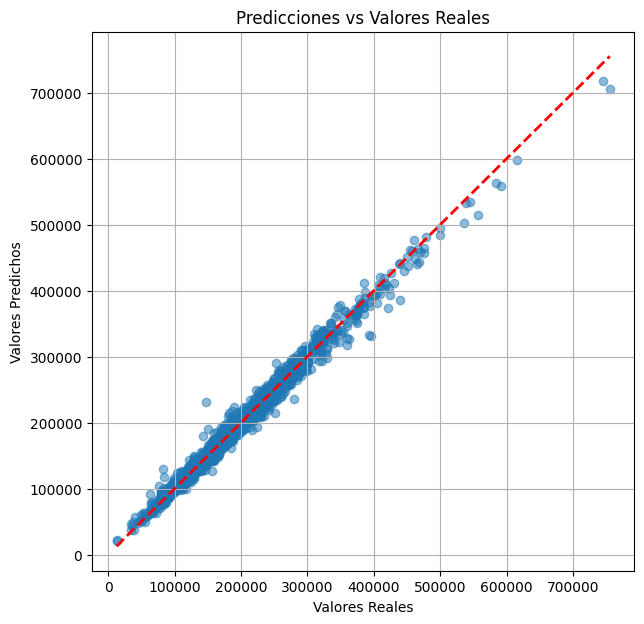

In [19]:
plt.figure(figsize=(7,7))
plt.scatter(y_train, y_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)  # línea identidad
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Predicciones vs Valores Reales")
plt.grid(True)
plt.show()


## Análisis de Predicciones vs Valores Reales

El gráfico muestra la relación entre las predicciones del modelo y los valores reales.

- La mayoría de los puntos se encuentran cerca de la línea de identidad (línea roja discontinua), lo que indica que el modelo predice valores muy cercanos a los reales.
- La buena alineación sugiere que el modelo captura bien la tendencia general y realiza predicciones precisas en el rango observado.
- Algunos puntos alejados de la línea reflejan errores de predicción en casos particulares, lo cual es esperado en problemas de regresión con datos reales.

Este gráfico confirma la eficacia del modelo para ajustar y predecir correctamente los precios en el conjunto de datos.


[learning_curve] Training set sizes: [ 187  609 1031 1453 1875]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 15.7min finished


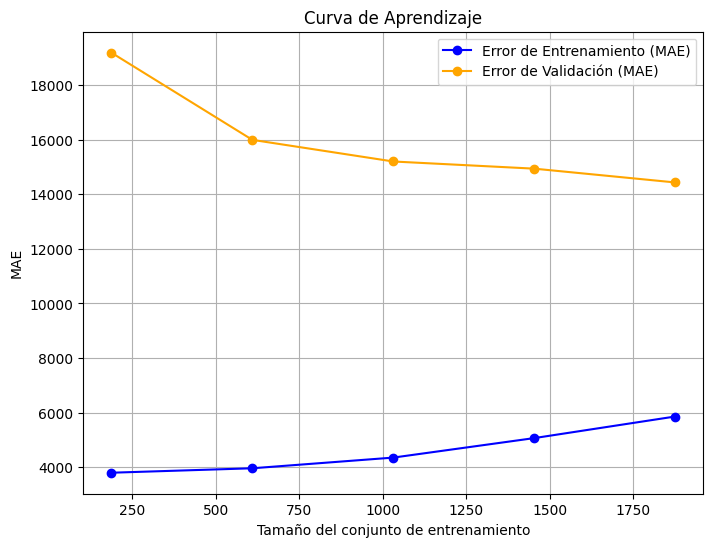

In [20]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_gpr, X_train_scaled, y_train, cv=cv, scoring='neg_mean_absolute_error',
    n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), verbose=1)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Error de Entrenamiento (MAE)')
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Error de Validación (MAE)')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('MAE')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.grid(True)
plt.show()


## Curva de Aprendizaje

La curva de aprendizaje muestra cómo varía el error (MAE) en el conjunto de entrenamiento y validación a medida que aumenta el tamaño del conjunto de entrenamiento.

- El **error de entrenamiento** (línea azul) aumenta ligeramente con más datos, indicando que el modelo se ajusta mejor con conjuntos pequeños y pierde algo de precisión con más datos, lo cual es esperado en modelos complejos como GPR.
- El **error de validación** (línea naranja) disminuye conforme se incrementa el tamaño del conjunto, reflejando que el modelo mejora su generalización con más datos.
- La brecha entre ambos errores indica un posible sesgo y varianza, aunque la tendencia sugiere que añadir más datos puede seguir mejorando el rendimiento.

Este análisis ayuda a entender el comportamiento del modelo frente a diferentes cantidades de datos y a identificar si el modelo se beneficia de más muestras.


In [21]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Añade constante para el modelo auxiliar
X_const = sm.add_constant(y_pred)
# Residuos al cuadrado (dependiente en regresión auxiliar)
residuos_sq = residuos ** 2

# Test Breusch-Pagan
bp_test = het_breuschpagan(residuos, X_const)

labels = ['LM stat', 'LM p-val', 'F stat', 'F p-val']
print("Test de Breusch-Pagan para heterocedasticidad:")
for label, value in zip(labels, bp_test):
    print(f"{label}: {value:.4f}")

if bp_test[1] < 0.05:
    print("Se rechaza la hipótesis nula: evidencia de heterocedasticidad.")
else:
    print("No se rechaza la hipótesis nula: no hay evidencia clara de heterocedasticidad.")


Test de Breusch-Pagan para heterocedasticidad:
LM stat: 189.4568
LM p-val: 0.0000
F stat: 205.9406
F p-val: 0.0000
Se rechaza la hipótesis nula: evidencia de heterocedasticidad.


## Justificación, Inferencia y Conclusión sobre la Heterocedasticidad

---

### Justificación del uso de la métrica

El **Test de Breusch-Pagan** se utiliza para detectar heterocedasticidad, es decir, si la varianza de los residuos del modelo es constante o varía con los valores predichos. Detectar heterocedasticidad es crucial porque la presencia de varianza no constante puede afectar la validez de inferencias estadísticas y la eficiencia de las estimaciones del modelo.

---

### Inferencia

Los resultados del test mostraron valores de:

- Estadísticos LM y F muy altos con p-valores cercanos a cero.
- Esto indica que **se rechaza la hipótesis nula** de homocedasticidad, evidenciando la presencia de heterocedasticidad en los residuos.

---

### Conclusión

Aunque el modelo Gaussian Process Regressor proporciona un buen ajuste general, la presencia de heterocedasticidad sugiere que la varianza del error no es constante en todo el rango de predicción. Esto puede requerir técnicas adicionales, como transformaciones de variables o modelos robustos, para mejorar la precisión y confiabilidad en regiones específicas del espacio de predicción.

Este análisis complementa la evaluación del modelo, aportando información valiosa para futuras mejoras y para interpretar los resultados con cautela.
